In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]; error_rate=[];

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            oob_error = 1 - clf.oob_score_
            error_rate.append(oob_error)
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
#             print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f, oob: %.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
#                                                                                  spec,auroc_train,auroc,oob_error))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f, oob=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all),
        np.nanmean(error_rate),np.nanstd(error_rate)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres,error_rate
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path

## Load unpacked features data

In [5]:
filename = 'Features_AllLocsHP+LP_Hand.pkl'
# filename = 'Features_AllLocsBP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [6]:
Data[np.isnan(Data.Bradykinesia)]

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
657,1004,2 Weeks: Time 0,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.009879,0.009085,0.013134,...,903.072589,5.874919,33.301614,0.016708,10.928537,1.207032,13.543522,0.107217,0.217278,0.033863
658,1004,2 Weeks: Time 0,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.007454,0.004400,0.010677,...,81.719174,4.558531,21.008422,0.097832,3.600419,-0.170117,-0.534583,0.370784,0.448930,0.871547
659,1004,2 Weeks: Time 30,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.011242,0.008110,0.011167,...,1136.056722,5.820616,32.833043,0.050114,14.762677,2.984677,33.986823,0.046903,0.042687,0.054171
660,1004,2 Weeks: Time 30,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.012806,0.008750,0.013621,...,2399.777355,2.789891,6.546759,0.575757,22.170208,0.246361,8.801843,0.225942,0.338912,0.179001
661,1004,2 Weeks: Time 30,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.010222,0.008350,0.012365,...,463.351985,2.811187,7.733982,0.407438,22.986711,-1.442363,7.347887,0.305088,0.388368,0.109852
662,1004,2 Weeks: Time 60,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.008009,0.004348,0.010798,...,132.495496,3.884965,16.089274,0.047153,4.605133,-0.337244,2.291948,0.475972,0.473486,0.643178
663,1004,2 Weeks: Time 60,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.010062,0.012235,0.012082,...,61.355632,2.246120,4.489009,1.464303,8.842312,1.638841,4.948208,0.397688,0.471175,0.097942
664,1004,2 Weeks: Time 90,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.006815,0.013980,0.014833,...,3448.171159,4.930176,24.577845,0.078180,26.689605,-3.048159,34.969908,0.142782,0.303223,0.044463
665,1004,2 Weeks: Time 90,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.010240,0.016223,0.010934,...,95.971235,3.157957,9.253988,-0.022663,22.174568,2.621264,33.943032,0.130479,0.322655,0.045810
666,1004,2 Weeks: Time 120,left,Motor #6: Sit to Stand,0.0,NaN,0.0,0.013084,0.011177,0.013835,...,1526.706689,5.177251,26.850290,0.161929,19.507459,-1.204697,21.905197,0.135889,0.233094,0.048838


In [7]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [8]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [9]:
Data.shape

(40377, 63)

In [10]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

# ALL TASKS


Text(0.5,1,'Tremor')

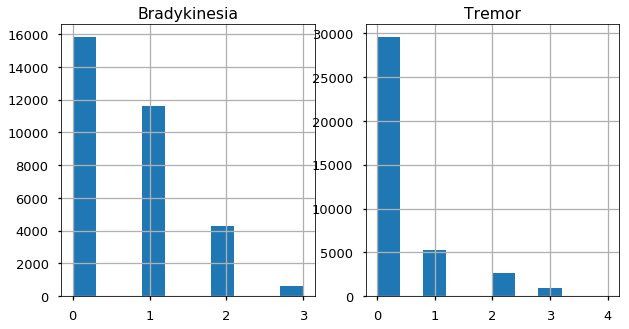

In [11]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(Text(0.5,1,'Tremor - Symptoms > 0 per Task'), Text(0.5,0,'Task'))

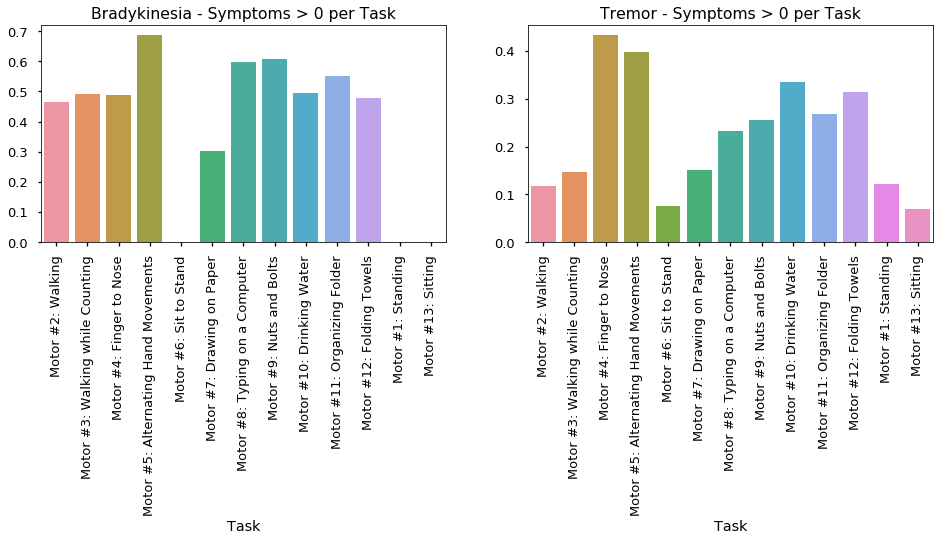

In [12]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

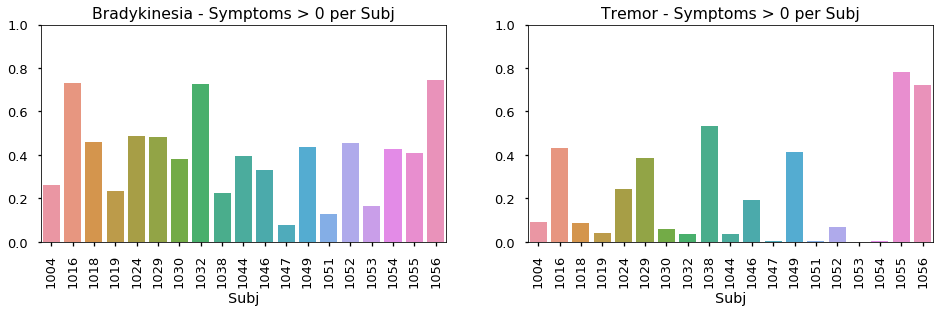

In [13]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

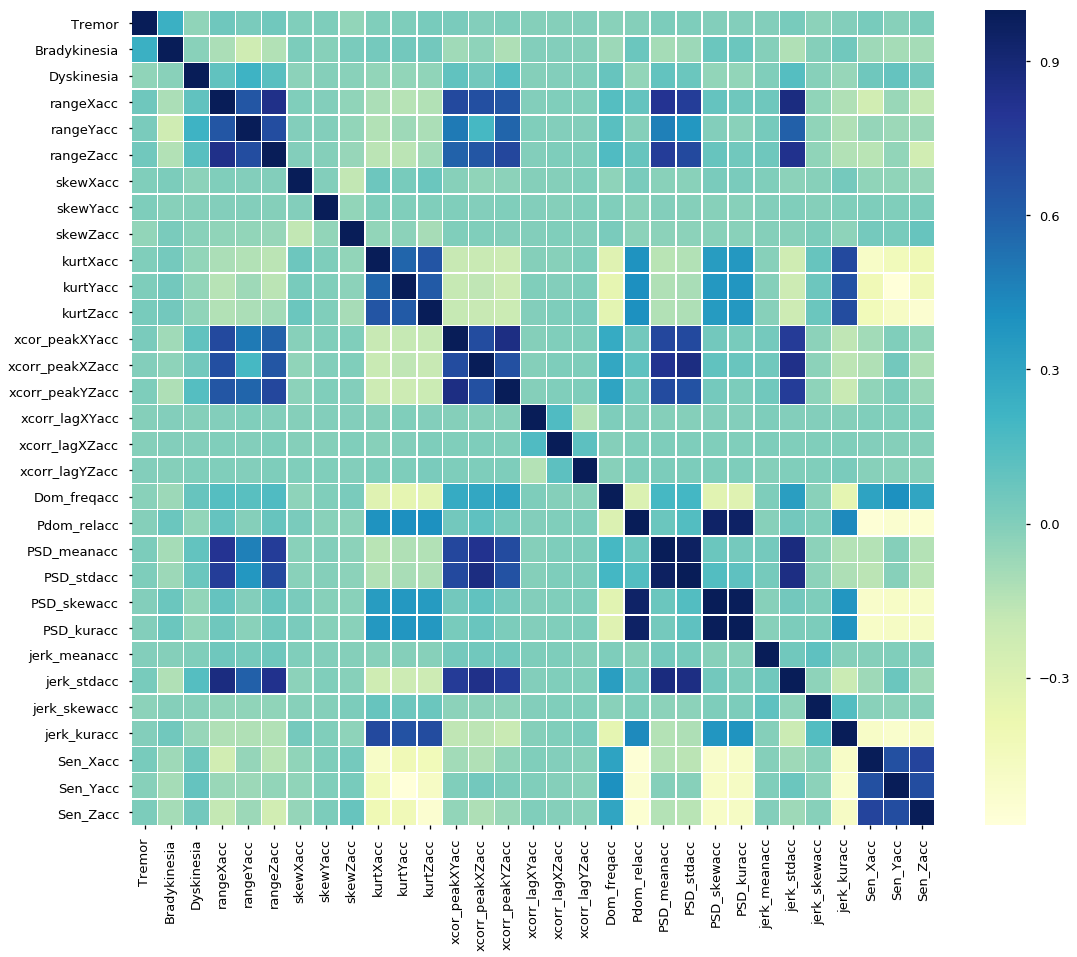

In [14]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

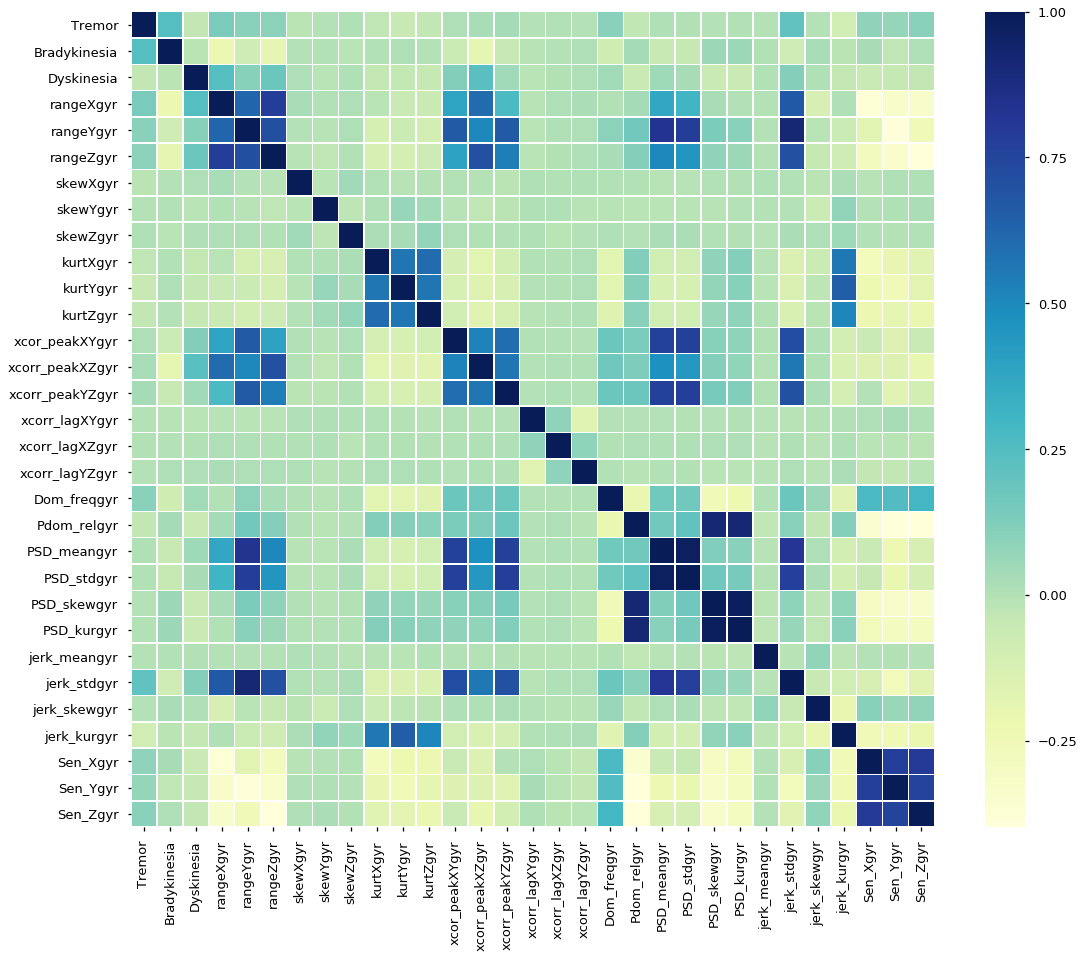

In [15]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## LOSO CV - ALL TASKS

In [93]:
t1=time.time()
res_all = pd.DataFrame()

subs = pd.DataFrame(subjs,columns=['subject'])
errors = pd.DataFrame(subs)
# trees = list([10,20,25,30,35,40,45,50,60,70,80,90,100,200,250,500,750,1000])
trees = list([10,25,50,100,200,400])

for ii in trees:
    print('number of trees: %d'%ii)
#     for symptom in ['Bradykinesia']:
    for symptom in ['Tremor']:
    
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)
        fnames = Data.iloc[:,7:].columns.values

        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

        models = [RandomForestClassifier(n_estimators=ii,random_state=2,oob_score=True)]          
    #           XGBClassifier()]
        model_name = ['Random Forest']#,'XGB']
        models = list(zip(models,model_name))
        groups = Data.Subject.as_matrix()

        res,res_group,error_rate = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        oob = pd.DataFrame(error_rate,columns=[ii])
        errors = pd.concat([errors,oob],axis=1)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

number of trees: 10
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably me

only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably me

f1_test=0.267+/-0.165, prec=0.436+/-0.321, rec=0.249+/-0.132, auprc=0.413+/-0.293, auroc=0.731+/-0.084, oob=0.204+/-0.010
number of trees: 25
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
f1_test=0.307+/-0.183, prec=0.464+/-0.321, rec=0.300+/-0.168, auprc=0.446+/-0.294, auroc=0.766+/-0.091, oob=0.176+/-0.009
number of trees: 50
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
f1_test=0.304+/-0.186, prec=0.509+/-0.337, rec=0.267+/-0.158, auprc=0.465+/-0.294, auroc=0.780+/-0.092, oob=0.164+/-0.009
number of trees: 100
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
f1_test=0.312+/-0.195, prec=0.514+/-0.335, rec=0.274+/-0.166, auprc=0.474+/-0.297, auroc=0.789+/-0.095, oob=0.157+/-0.008
number of trees: 200
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
f1_test=0.317+/-0.197, prec=0.525+/-0.343, rec=0.278+/-0.165, auprc=0.482+/-0.295, auroc=0.794+/-0.096, oob=0.154+/-0.007
number of trees: 400
Rows w Tremor 8169/32330 = 0.25
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
f1_test=0.322+/-0.199, prec=0.529+/-0.344, rec=0.284+/-0.163, auprc=0.486+/-0.296, auroc=0.795+/-0.096, oob=0.152+/-0.007
Elapsed time = 51.411 min


In [94]:
errors.to_csv(os.path.join(features_path,'oob_error_tremor.csv'),index=False)

In [95]:
df = errors.reset_index(drop=True).set_index('subject')
df.head()

,10,25,50,100,200,400
subject,,,,,,
1004,0.208950,0.179593,0.167388,0.160423,0.156810,0.153979
1016,0.186577,0.157482,0.148002,0.141967,0.139113,0.137407
1018,0.209803,0.182439,0.167516,0.161964,0.156544,0.155760
1019,0.209740,0.181279,0.169653,0.161890,0.157534,0.156159
1024,0.198539,0.170794,0.157691,0.151730,0.149142,0.146325


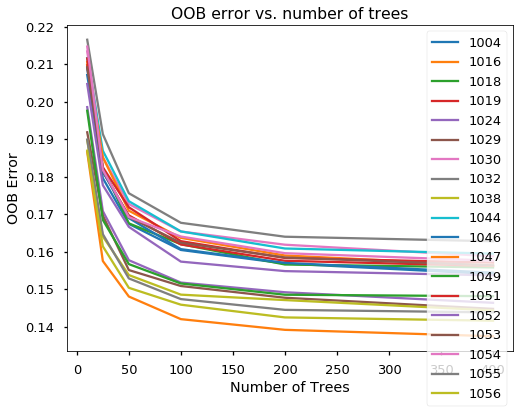

In [97]:
ax = plt.figure(figsize=(8,6))

for ii in list(errors.subject):
    dat = df.loc[int(ii)]
    dat.plot()
plt.legend(list(errors.subject));
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB error vs. number of trees')
plt.savefig('oob_error_tremor.png',bbox_inches='tight')

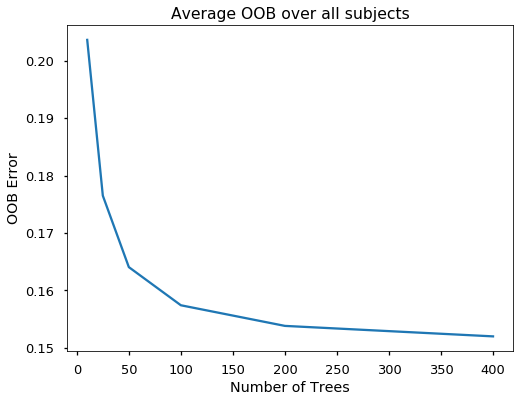

In [98]:
plt.figure(figsize=(8,6))
avgData = np.mean(df,axis=0)
avgData.plot();
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('Average OOB over all subjects')
plt.savefig('oob_error_avg_tremor.png',bbox_inches='tight')

In [17]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056], dtype=int64)

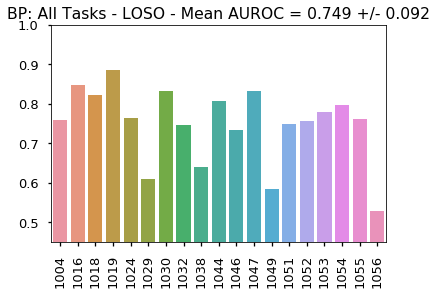

In [18]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('BP: All Tasks - LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('BP_Brady_LOSO_AllTasks.png',bbox_inches='tight');

### Feature importance

In [19]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

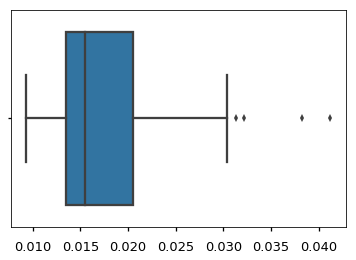

In [20]:
ax=sns.boxplot(meanfi)

In [21]:
fnames = Data.iloc[:,7:].columns.values


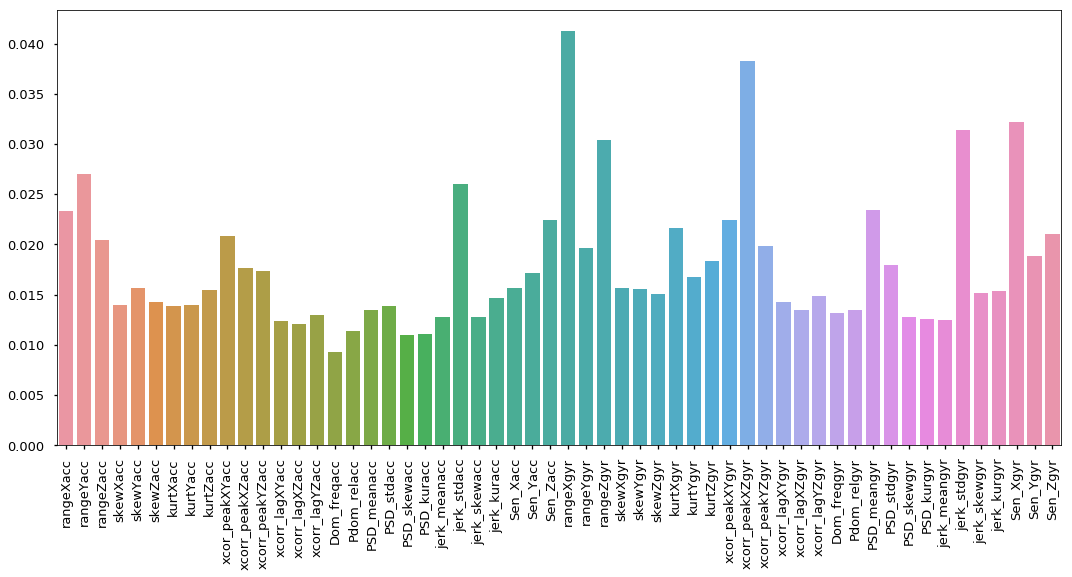

In [22]:
plt.figure(figsize=(18,8))
sns.barplot(x=np.arange(len(meanfi)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(meanfi)),fnames,rotation=90)

In [23]:
np.percentile(meanfi,75)

0.020521186630924504

In [24]:
sum(meanfi>0.02)

15

In [25]:
#top features
n = 13
fnames[np.argsort(meanfi)[::-1]][:n]

array(['rangeXgyr', 'xcorr_peakXZgyr', 'Sen_Xgyr', 'jerk_stdgyr',
       'rangeZgyr', 'rangeYacc', 'jerk_stdacc', 'PSD_meangyr',
       'rangeXacc', 'xcor_peakXYgyr', 'Sen_Zacc', 'kurtXgyr', 'Sen_Zgyr'],
      dtype=object)

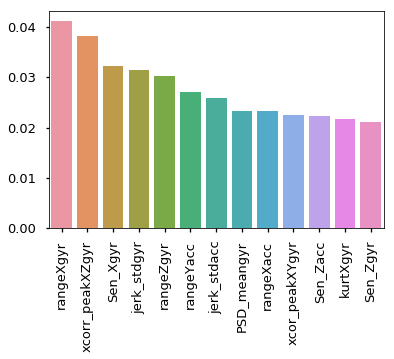

In [26]:
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames[np.argsort(meanfi)[::-1]][:n],rotation=90)

In [27]:
t1=time.time()
res_all = pd.DataFrame()

recall = []; precision = [];

for symptom in ['Bradykinesia']:
# for symptom in ['Tremor']:

    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
    
    #top features
    n = 13
    topf = fnames[np.argsort(meanfi)[::-1]][:n]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/40377 = 0.41
Training Random Forest

Subj/Visit 0, prec=0.482, rec=0.550, Spec=0.789, auroc_train=1.000, auroc=0.765

Subj/Visit 1, prec=0.910, rec=0.681, Spec=0.815, auroc_train=1.000, auroc=0.848

Subj/Visit 2, prec=0.761, rec=0.565, Spec=0.849, auroc_train=1.000, auroc=0.815

Subj/Visit 3, prec=0.473, rec=0.858, Spec=0.710, auroc_train=1.000, auroc=0.861

Subj/Visit 4, prec=0.718, rec=0.523, Spec=0.806, auroc_train=1.000, auroc=0.750

Subj/Visit 5, prec=0.552, rec=0.577, Spec=0.565, auroc_train=1.000, auroc=0.593

Subj/Visit 6, prec=0.659, rec=0.719, Spec=0.770, auroc_train=1.000, auroc=0.828

Subj/Visit 7, prec=0.886, rec=0.437, Spec=0.852, auroc_train=1.000, auroc=0.780

Subj/Visit 8, prec=0.315, rec=0.456, Spec=0.714, auroc_train=1.000, auroc=0.651

Subj/Visit 9, prec=0.642, rec=0.663, Spec=0.756, auroc_train=1.000, auroc=0.788

Subj/Visit 10, prec=0.545, rec=0.502, Spec=0.792, auroc_train=1.000, auroc=0.741

Subj/Visit 11, prec=0.237, rec=0.660, Spec=0.

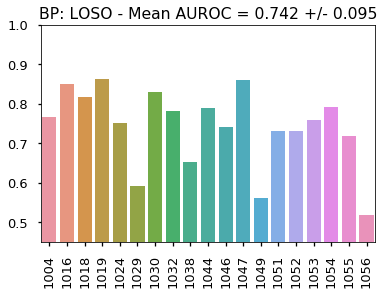

In [28]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('BP: LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('BP_Brady_LOSO_TopTasks.png',bbox_inches='tight');

## Personal Models

In [29]:
symptom = 'Bradykinesia'
# symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 
for s in Data.Subject.unique():
    print('Subject %s'%s)
    
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.776, rec=0.185, Spec=0.840, auroc_train=1.000, auroc=0.794

Subj/Visit 1, prec=0.190, rec=0.114, Spec=0.928, auroc_train=1.000, auroc=0.690

Subj/Visit 2, prec=0.607, rec=0.708, Spec=0.958, auroc_train=1.000, auroc=0.962

Subj/Visit 3, prec=0.637, rec=0.586, Spec=0.859, auroc_train=1.000, auroc=0.805

Subj/Visit 4, prec=0.463, rec=0.731, Spec=0.911, auroc_train=1.000, auroc=0.945

Subj/Visit 5, prec=0.862, rec=0.543, Spec=0.982, auroc_train=1.000, auroc=0.918

Subj/Visit 6, prec=0.623, rec=0.581, Spec=0.891, auroc_train=1.000, auroc=0.838
f1_test=0.506+/-0.188, prec=0.594+/-0.203, rec=0.493+/-0.227, auprc=0.621+/-0.183, auroc=0.850+/-0.090
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.929, rec=0.936, Spec=0.791, auroc_train=1.000, auroc=0.960

Subj/Visit 1, prec=0.850, rec=0.983, Spec=0.554, auroc_train=1.000, auroc=0.927

Subj/Visit 2, prec=0.850, rec=0.973, Spec=0.596, auroc_train=1.000, auroc=0.905

Subj/Visit 3, 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.365, Spec=1.000, auroc_train=1.000, auroc=0.888


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan
f1_test=0.145+/-0.230, prec=0.267+/-0.423, rec=0.100+/-0.158, auprc=0.784+/-0.012, auroc=0.886+/-0.001
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.798, rec=0.457, Spec=0.909, auroc_train=1.000, auroc=0.780

Subj/Visit 1, prec=0.856, rec=0.801, Spec=0.895, auroc_train=1.000, auroc=0.895

Subj/Visit 2, prec=0.836, rec=0.772, Spec=0.874, auroc_train=1.000, auroc=0.902

Subj/Visit 3, prec=0.922, rec=0.599, Spec=0.959, auroc_train=1.000, auroc=0.911

Subj/Visit 4, prec=0.836, rec=0.736, Spec=0.882, auroc_train=1.000, auroc=0.886

Subj/Visit 5, prec=0.805, rec=0.673, Spec=0.869, auroc_train=1.000, auroc=0.871

Subj/Visit 6, prec=0.436, rec=0.560, Spec=0.534, auroc_train=1.000, auroc=0.551
f1_test=0.706+/-0.115, prec=0.784+/-0.147, rec=0.657+/-0.115, auprc=0.808+/-0.145, auroc=0.828+/-0.120
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.0

In [30]:
#compute mean and std auc
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    while len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

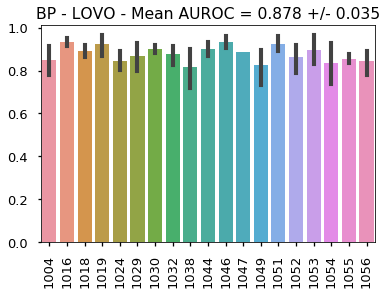

In [31]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('BP - LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.savefig('BP_Brady_Personal.png',bbox_inches='tight');